In [1]:
import pandas as pd #data preprocessing
import itertools #confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
#To show all the rows of pandas dataframe
pd.set_option('display.max_rows',None)

In [2]:
df = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')

In [3]:
df.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

In [4]:
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                               

In [5]:
df_train=df[(df['condition']=='Depression')|(df['condition']=='Anxiety')|(df['condition']=='Migraine')|(df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')|(df['condition']=='Insomnia')]

In [6]:
df.shape

(161297, 7)

In [7]:
df_train.shape

(25215, 7)

In [8]:
X=df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

EDA

In [9]:
X.condition.value_counts()

condition
Depression             9069
Anxiety                5904
Insomnia               3673
Diabetes, Type 2       2554
High Blood Pressure    2321
Migraine               1694
Name: count, dtype: int64

In [10]:
X.head()

condition                                             review
11  Depression  "I have taken anti-depressants for years, with...
21    Insomnia  "I have insomnia, it&#039;s horrible. My story...
29    Migraine  "At first I suffered through them. This includ...
31  Depression  "1 week on Zoloft for anxiety and mood swings....
44  Depression  "my gp started me on Venlafaxine yesterday to ...

In [11]:
#segregating dataframe for analyzing individual condition
X_dep=X[(X['condition']=='Depression')]
X_anx=X[(X['condition']=='Anxiety')]
X_ins=X[(X['condition']=='Insomnia')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_mig=X[(X['condition']=='Migraine')]


Text(0.5, 1.0, 'Word Cloud for Depression')

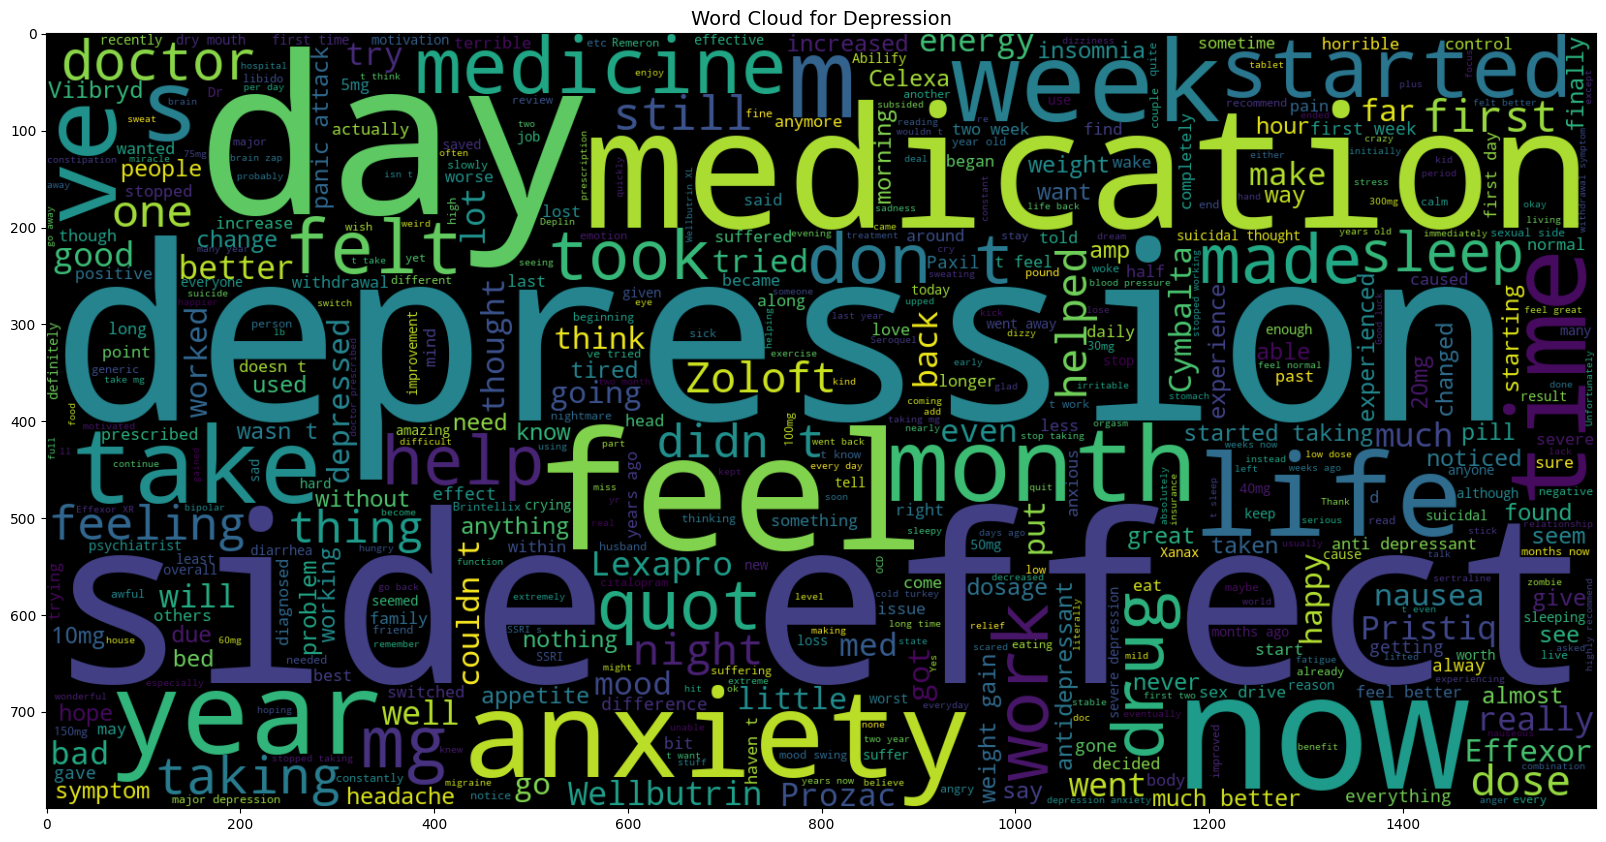

In [12]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=500,width=1600,height=800).generate(" ".join(X_dep.review))
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud for Depression',fontsize=14)

Text(0.5, 1.0, 'Word Cloud for Anxiety')

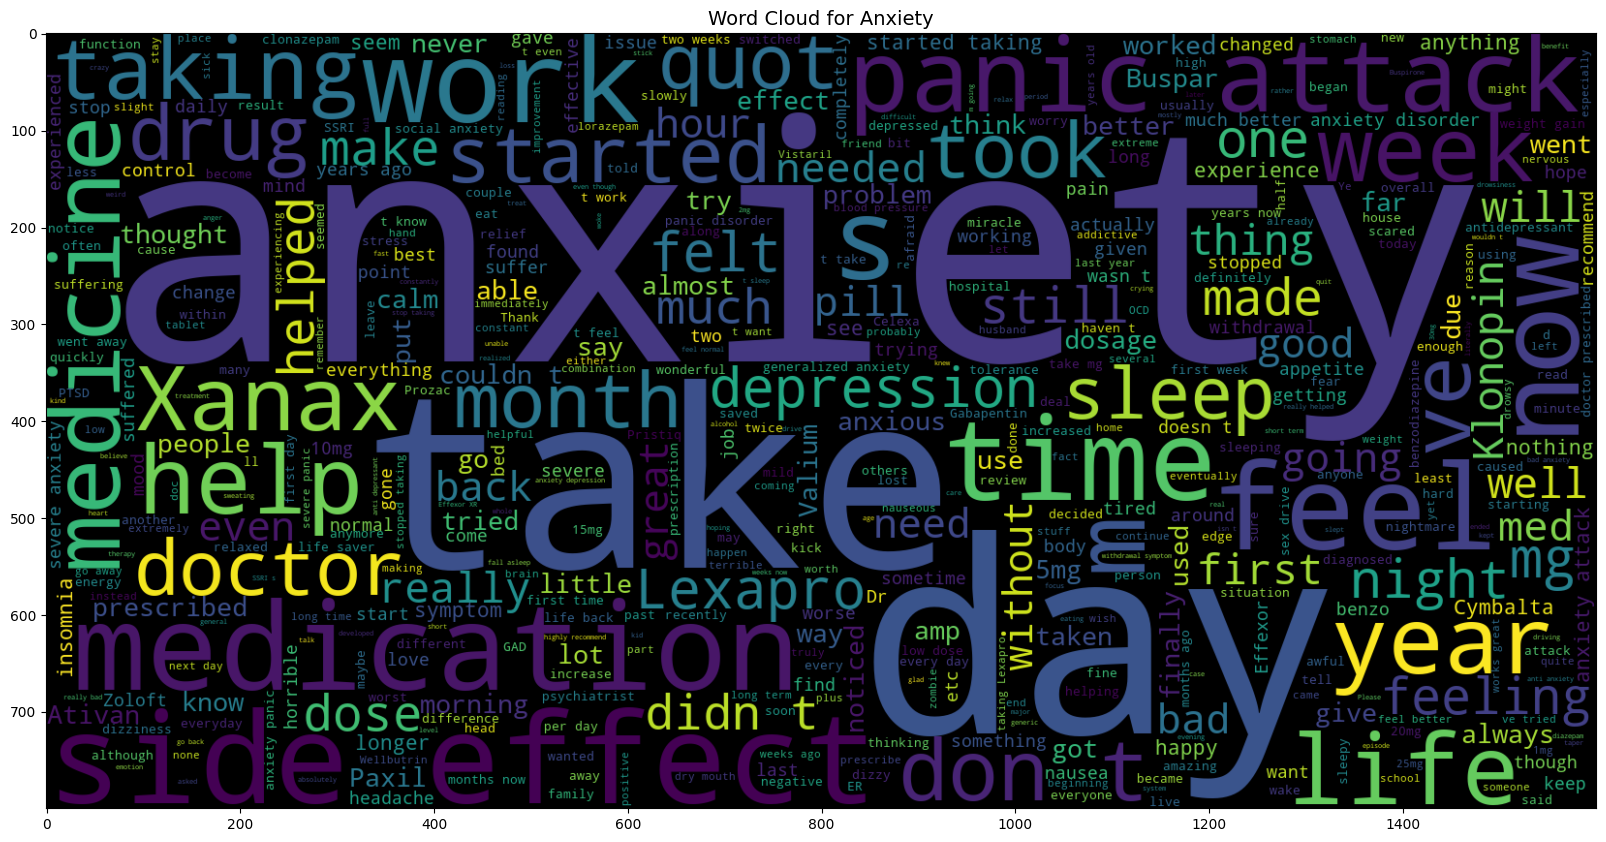

In [15]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=500,width=1600,height=800).generate(" ".join(X_anx.review))
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud for Anxiety',fontsize=14)

Text(0.5, 1.0, 'Word Cloud for Insomnia')

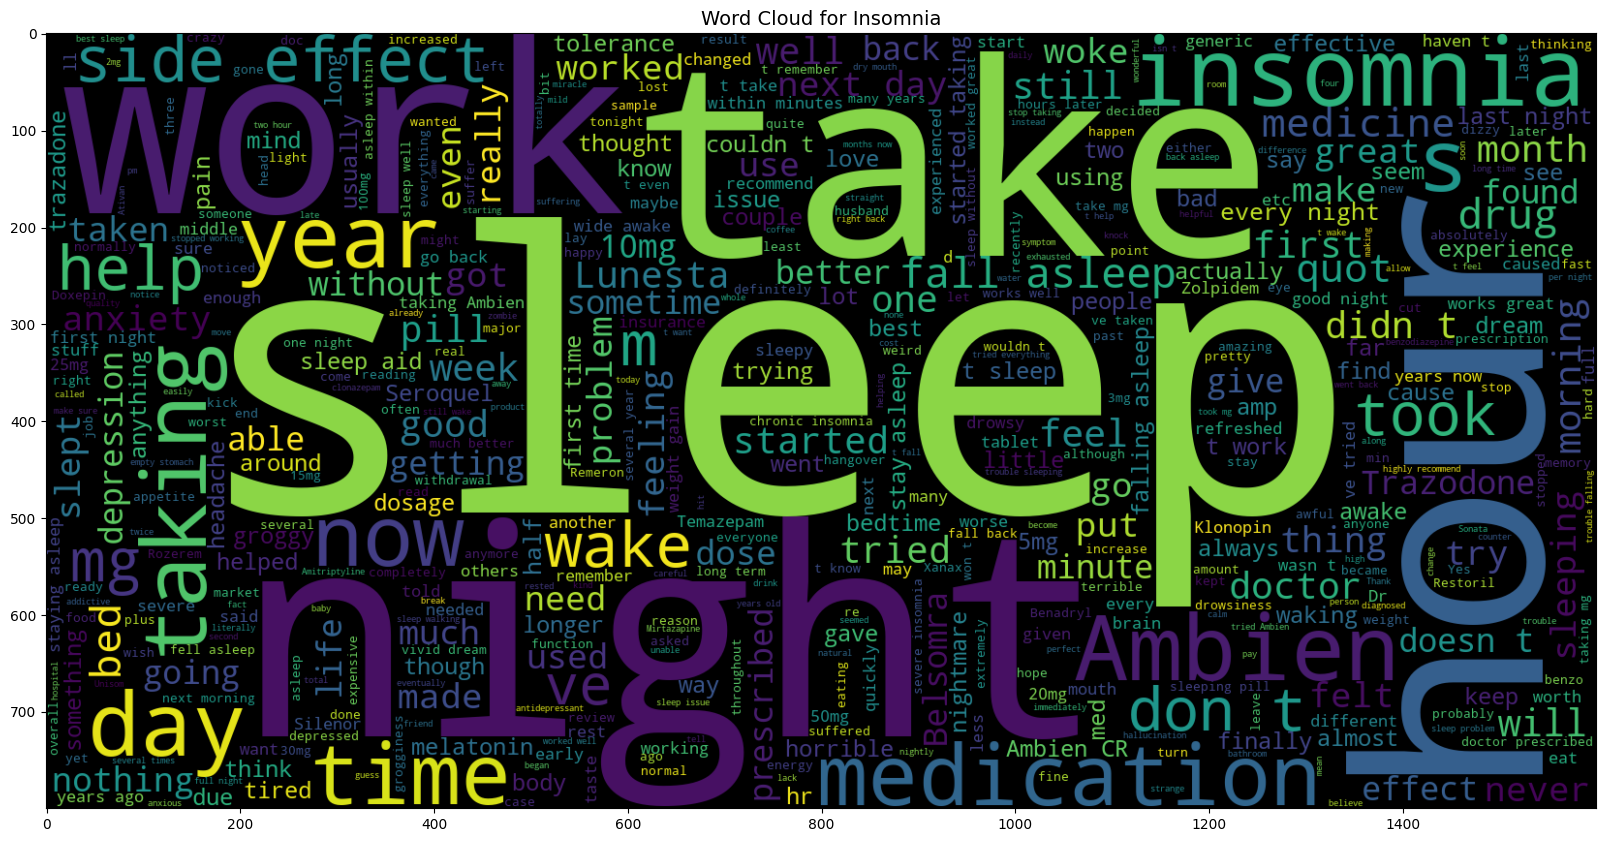

In [16]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=500,width=1600,height=800).generate(" ".join(X_ins.review))
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud for Insomnia',fontsize=14)

Text(0.5, 1.0, 'Word Cloud for Diabetes, Type 2')

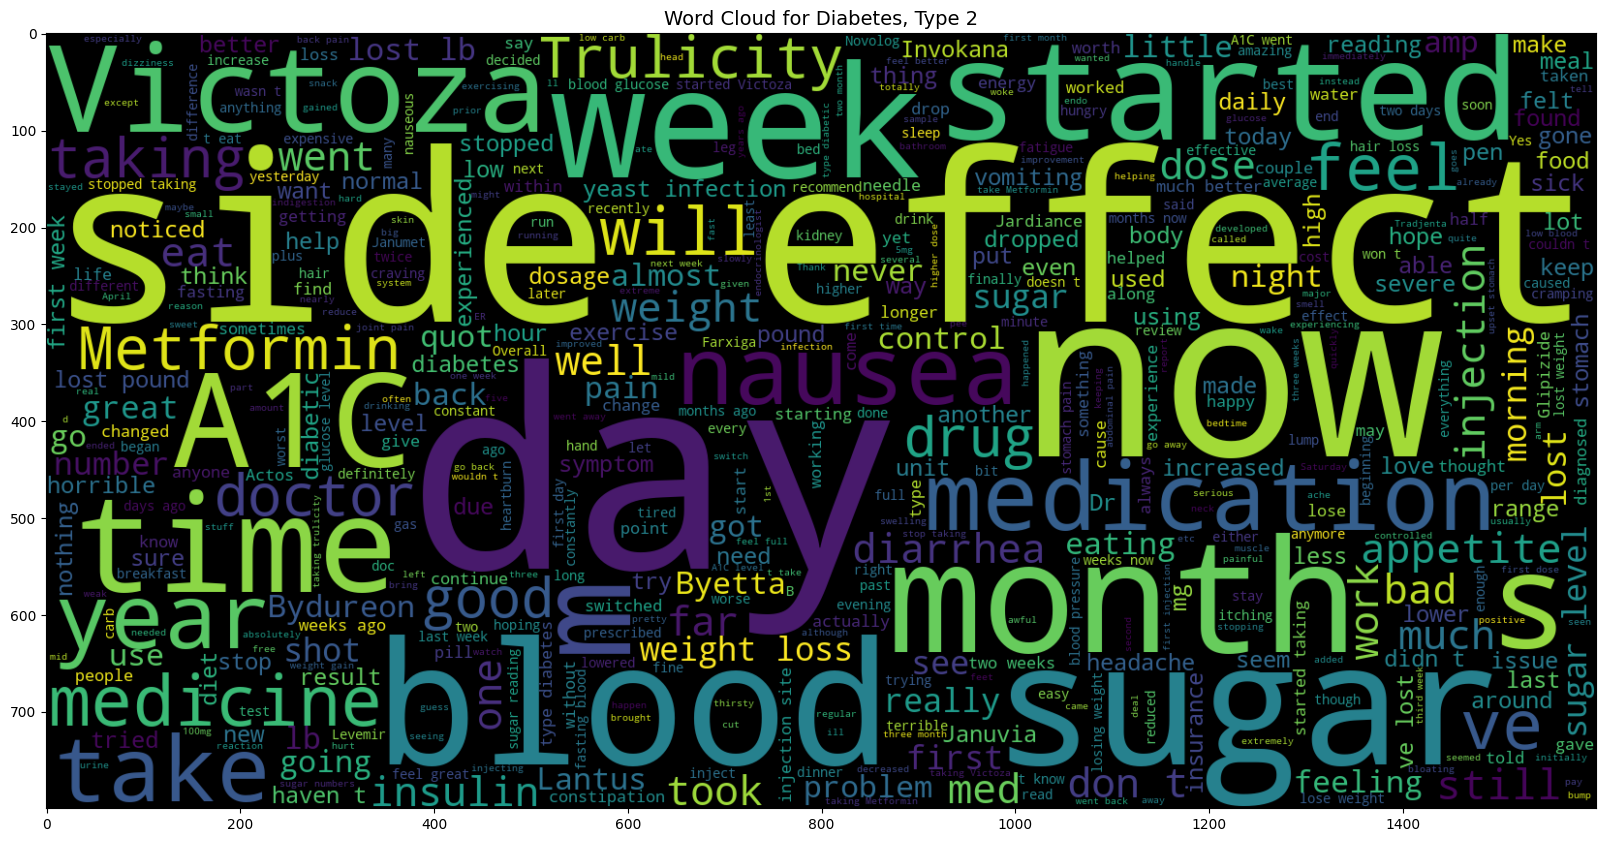

In [17]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=500,width=1600,height=800).generate(" ".join(X_diab.review))
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud for Diabetes, Type 2',fontsize=14)

Text(0.5, 1.0, 'Word Cloud for High Blood Pressure')

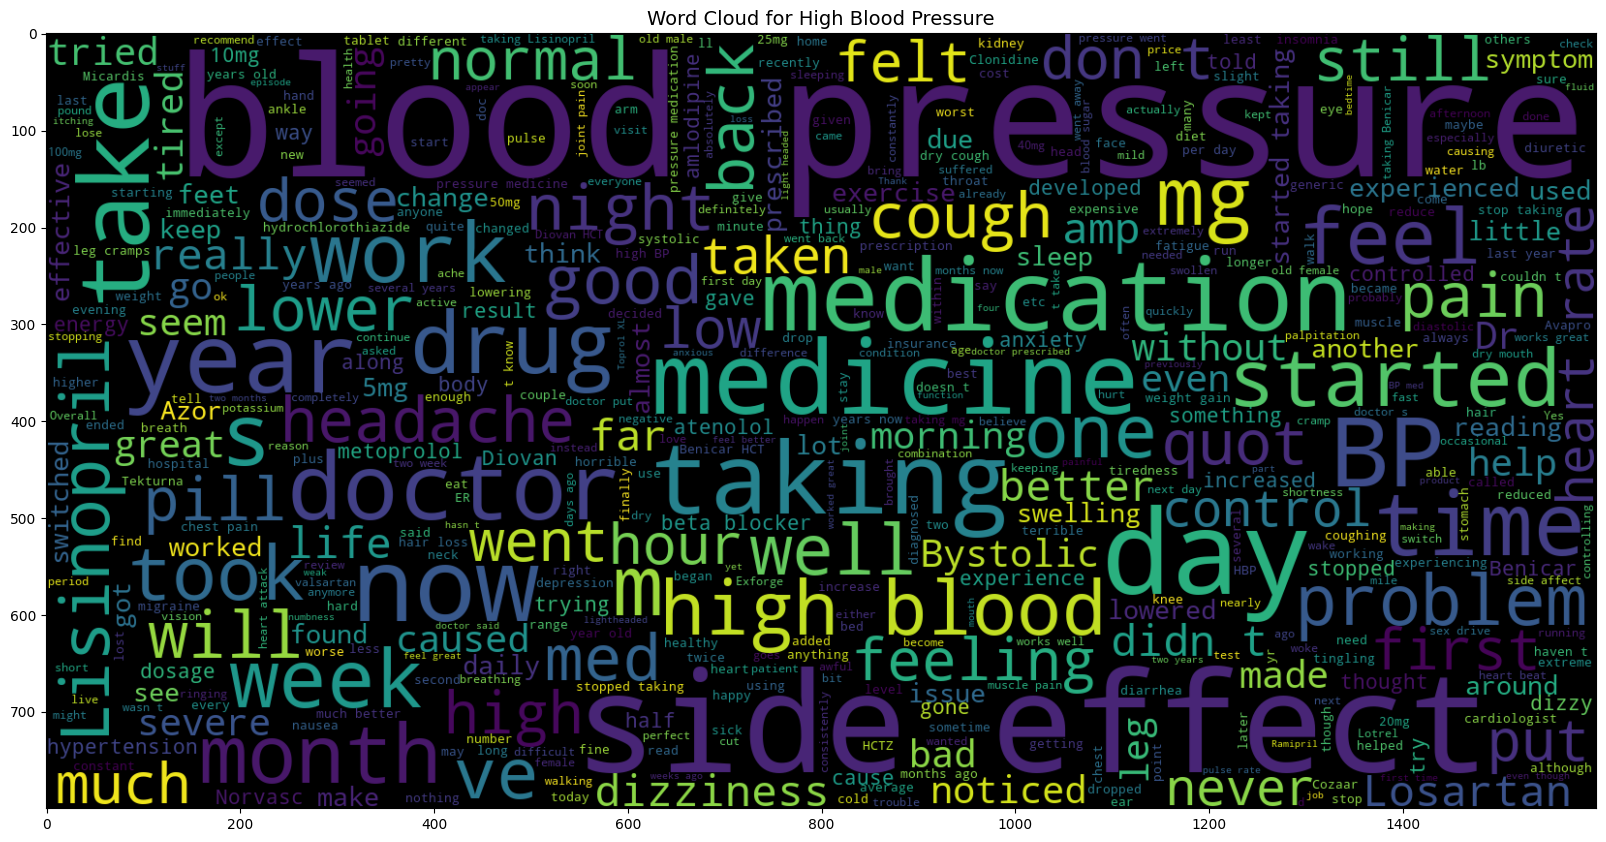

In [18]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=500,width=1600,height=800).generate(" ".join(X_bp.review))
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud for High Blood Pressure',fontsize=14)

Text(0.5, 1.0, 'Word Cloud for Migraine')

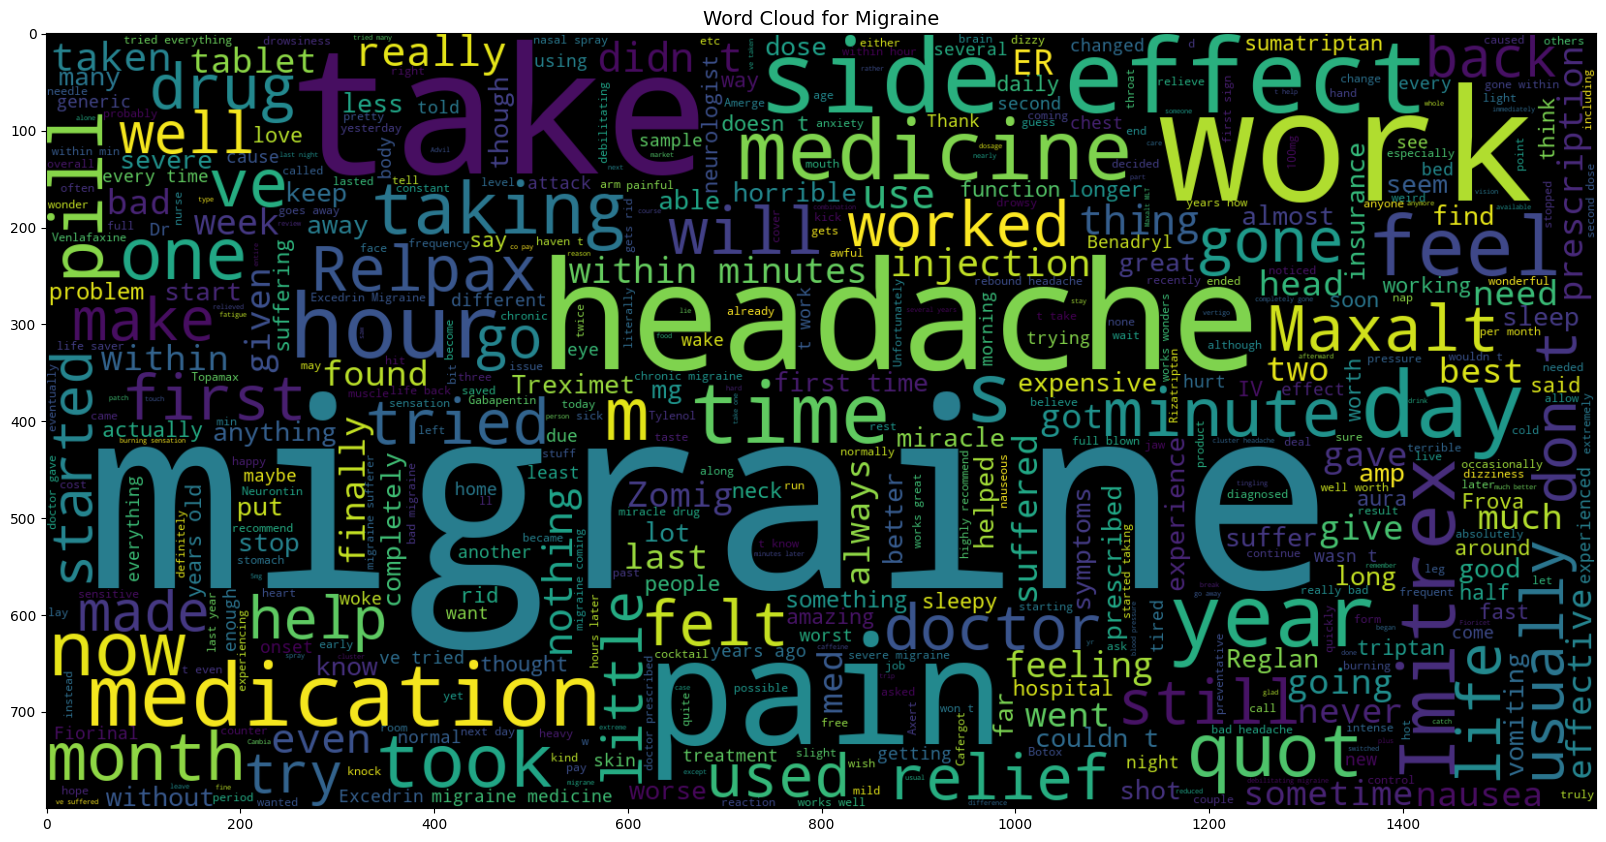

In [19]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=500,width=1600,height=800).generate(" ".join(X_mig.review))
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud for Migraine',fontsize=14)

Data preprocessing

In [21]:
X['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [22]:
X['review'][21]

'"I have insomnia, it&#039;s horrible. My story begins with my PCP prescribing me Prozac to help with intestinal issues, because I was desperate I tried it, I was on it for 3 weeks. Stopped because of insomnia. Then I was prescribed Ativan, it out me out, but was very addicting. I had rebound insomnia. Then after about 14 days I hardly any sleep l tried the doctor one more time. I asked him about Trazadone. He told me that was a good medication for insomnia. He put me on 25 mgs, but stated I may have to figure out what dosage is best for me. I am currently taking 100 mgs, which is on the low range of what is prescribed, 400 mgs being at the high end for insomnia. I have the dry mouth and nasel congestion. I can live with that, I sleep now, yeah..."'

In [23]:
for i,col in enumerate(X.columns):
  X.iloc[:,i]=X.iloc[:,i].str.replace('"','')

In [24]:
#To set the width of the column to maximum
pd.set_option('max_colwidth', None)

In [25]:
X.head()

condition  \
11  Depression   
21    Insomnia   
29    Migraine   
31  Depression   
44  Depression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 review  
11                                                                                                                                                                                                                                                                                                   I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.  
21  I have insomnia, it&#039;s horrible. My story begins with my PCP prescribing me Prozac to help with intestinal issues, because I was desperate I tried it, I was on it for 3 weeks. Stopped because of insomnia. Then I was prescribed Ativan, it out me out, but was very addicting. I had rebound insomnia. Then after about 14 days I hardly any sleep l tried the doctor one more time. I asked him about Trazadone. He told me that was a good medication for insomnia. He put me on 25 mgs, but stated I may have to figure out what dosage is best for me. I am currently taking 100 mgs, which is on the low range of what is prescribed, 400 mgs being at the high end for insomnia. I have the dry mouth and nasel congestion. I can live with that, I sleep now, yeah...  
29             At first I suffered through them. This included splitting head pain, nausea, and vomiting. I started using Excedrin after a while which helped if I took it right away. Then that started to not work so well anymore. I had one really bad one that lasted hours. I was still throwing up at 9 pm and I was now throwing up blood. I went to the ER and when I finally got in they put me on an IV to hydrate me. They then added Imitrex to the bag and I soon started feeling side effects. My head felt like I was going to pass out. My breathing became labored and it felt like someone was sitting on my chest. They said that meant it was working. After about two minutes everything was gone. I got pills to take at home and they worked okay. Not as fast.  
31                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        1 week on Zoloft for anxiety and mood swings. I take 50mg in the mornings with my breakfast. Nausea on day one  but that subsided as the week went on.  I get the jitters about 2 hrs after taking it followed by yawning. I feel much better though and less angry/stressed.  
44                                                my gp started me on Venlafaxine yest

**What are stopwords?**
Stopwords are the most common words in any natural language. For the purpose of building NLP models, these stopwords might not add ...... meaning of document.
The most common words used in a text are "the","is","in","for","where","when","to","at" etc.

In [26]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\College.DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

**Lemmitization**
Lemmatization is the process of reducing a word to its base or dictionary form, known as a "lemma." Unlike stemming, which merely chops off prefixes or suffixes, lemmatization involves a more sophisticated analysis of the word's meaning and context. It uses vocabulary and rules of morphology to return the word to its root form.

In [28]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

porter=PorterStemmer()

lemmatizer=WordNetLemmatizer()

In [29]:
print(porter.stem("sportingly"))
print(porter.stem("very"))
print(porter.stem("troubled"))

sportingli
veri
troubl


In [30]:
nltk.download('wordnet')

print(lemmatizer.lemmatize("sportingly"))
print(lemmatizer.lemmatize("very"))
print(lemmatizer.lemmatize("troubled"))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\College.DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


sportingly
very
troubled


In [31]:
from bs4 import BeautifulSoup
import re

In [32]:
def review_to_words(raw_review):
  #Delete HTML
  review_text=BeautifulSoup(raw_review,'html.parser').get_text()
  #Make a space
  letter_only=re.sub('[^a-zA-Z]',' ', review_text)
  #Lower letters
  words=letter_only.lower().split()
  #Stopwords
  meaningful_words=[w for w in words if not w in stop]
  #Lemmitization
  lemmitize_words=[lemmatizer.lemmatize(w) for w in meaningful_words]
  #space join words
  return(' '.join(lemmitize_words))

In [33]:
X['review_clean']=X['review'].apply(review_to_words)

C:\Users\College.DELL\AppData\Local\Temp\ipykernel_9036\71875438.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text=BeautifulSoup(raw_review,'html.parser').get_text()


In [34]:
X.head()

condition  \
11  Depression   
21    Insomnia   
29    Migraine   
31  Depression   
44  Depression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 review  \
11                                                                                                                                                                                                                                                                                                   I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.   
21  I have insomnia, it&#039;s horrible. My story begins with my PCP prescribing me Prozac to help with intestinal issues, because I was desperate I tried it, I was on it for 3 weeks. Stopped because of insomnia. Then I was prescribed Ativan, it out me out, but was very addicting. I had rebound insomnia. Then after about 14 days I hardly any sleep l tried the doctor one more time. I asked him about Trazadone. He told me that was a good medication for insomnia. He put me on 25 mgs, but stated I may have to figure out what dosage is best for me. I am currently taking 100 mgs, which is on the low range of what is prescribed, 400 mgs being at the high end for insomnia. I have the dry mouth and nasel congestion. I can live with that, I sleep now, yeah...   
29             At first I suffered through them. This included splitting head pain, nausea, and vomiting. I started using Excedrin after a while which helped if I took it right away. Then that started to not work so well anymore. I had one really bad one that lasted hours. I was still throwing up at 9 pm and I was now throwing up blood. I went to the ER and when I finally got in they put me on an IV to hydrate me. They then added Imitrex to the bag and I soon started feeling side effects. My head felt like I was going to pass out. My breathing became labored and it felt like someone was sitting on my chest. They said that meant it was working. After about two minutes everything was gone. I got pills to take at home and they worked okay. Not as fast.   
31                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        1 week on Zoloft for anxiety and mood swings. I take 50mg in the mornings with my breakfast. Nausea on day one  but that subsided as the week went on.  I get the jitters about 2 hrs after taking it followed by yawning. I feel much better though and less angry/stressed.   
44                                                my gp started me on Venlafaxine

Creating features and Target Variable

In [35]:
X_feat=X['review_clean']
y=X['condition']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, stratify=y, test_size=0.2, random_state=0)

In [37]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45) # Corrected the typo here: 'rotation' instead of 'roatation'
  plt.yticks(tick_marks, classes)
  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  thresh=cm.max() / 2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j]> thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Bag of words

In [38]:
count_vectorizer=CountVectorizer(stop_words='english')
count_train=count_vectorizer.fit_transform(X_train)
count_test=count_vectorizer.transform(X_test)

Machine Learning Model: Navie Bayes

accuracy: 0.840
Confusion matrix, without normalization


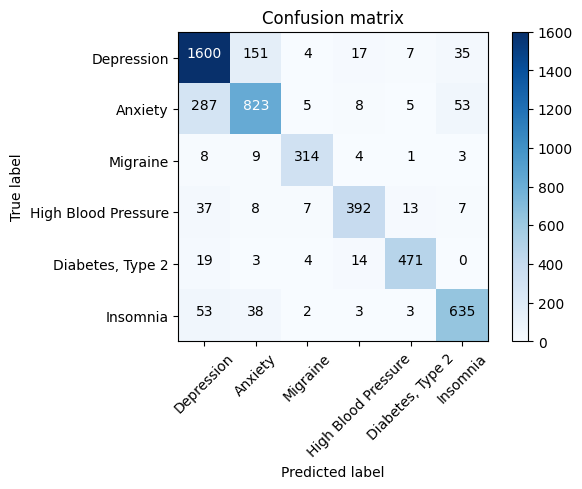

In [ ]:
mnb=MultinomialNB()
mnb.fit(count_train, y_train)
pred=mnb.predict(count_test)
score=metrics.accuracy_score(y_test,pred)
print("accuracy: %0.3f"%score)

cm=metrics.confusion_matrix(y_test, pred, labels=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])
plot_confusion_matrix(cm, classes=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])

Machine Learning Model: Passive Aggressive Classifier

accuracy: 0.855
Confusion matrix, without normalization


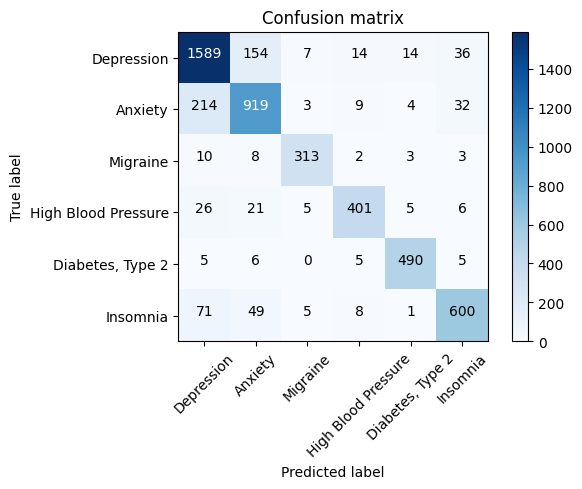

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

passive=PassiveAggressiveClassifier()
passive.fit(count_train,y_train)
pred=passive.predict(count_test)
score=metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" %score)

cm=metrics.confusion_matrix(y_test, pred, labels=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])
plot_confusion_matrix(cm, classes=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])

TFIDF

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer=TfidfVectorizer(stop_words='english',max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

Machine Learning Model: Navie Bayes

accuracy: 0.711
Confusion matrix, without normalization


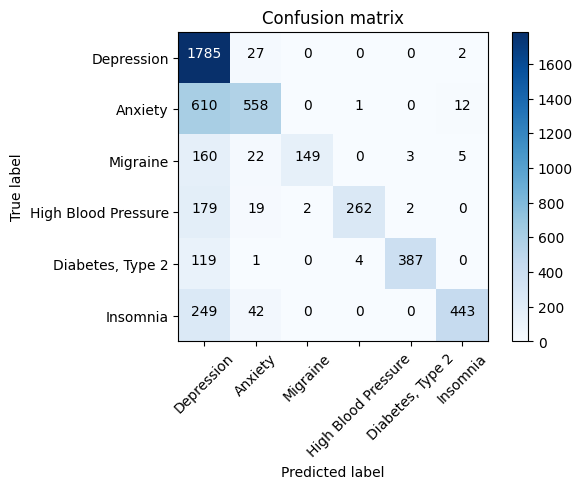

In [44]:
mnb_tf=MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred=mnb_tf.predict(tfidf_test_2)
score=metrics.accuracy_score(y_test,pred)
print("accuracy: %0.3f"%score)

cm=metrics.confusion_matrix(y_test, pred, labels=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])
plot_confusion_matrix(cm, classes=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])

Machine Learning Model TFIDF

accuracy: 0.862
Confusion matrix, without normalization


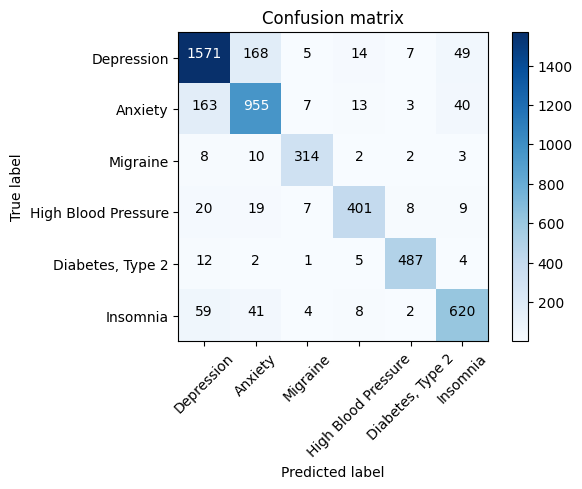

In [45]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english',max_df=0.8)
tfidf_train= tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf=PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train,y_train)
pred=pass_tf.predict(tfidf_test)
score=metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" %score)

cm=metrics.confusion_matrix(y_test, pred, labels=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])
plot_confusion_matrix(cm, classes=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])

TFIDF: Bigrams

In [46]:
tfidf_vectorizer2=TfidfVectorizer(stop_words='english',max_df=0.8,ngram_range=(1,2))
tfidf_train_2=tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2=tfidf_vectorizer2.transform(X_test)

accuracy: 0.903
Confusion matrix, without normalization


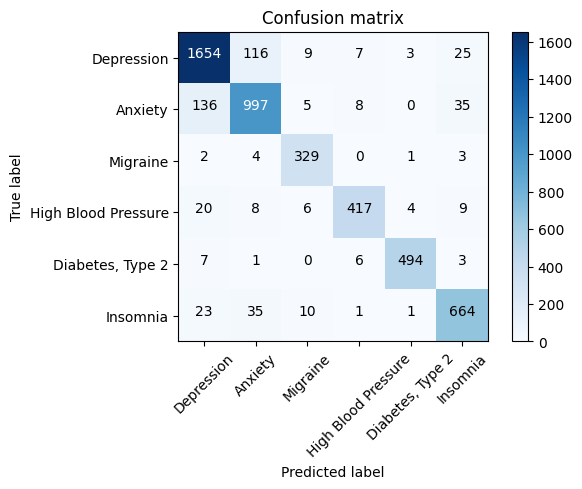

In [47]:
pass_tf=PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2,y_train)
pred=pass_tf.predict(tfidf_test_2)
score=metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" %score)

cm=metrics.confusion_matrix(y_test, pred, labels=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])
plot_confusion_matrix(cm, classes=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])

TFIDF: Trigrams

accuracy: 0.904
Confusion matrix, without normalization


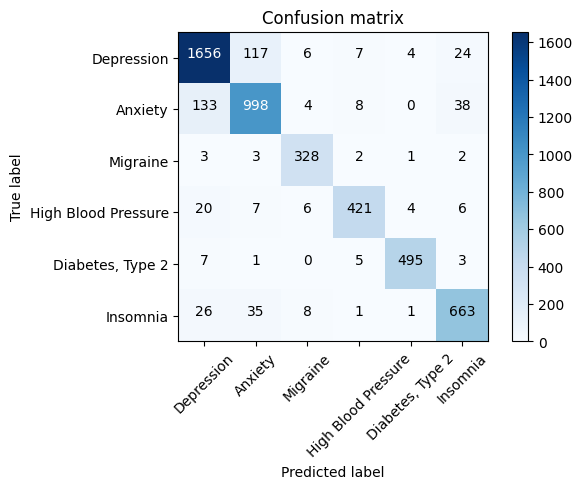

In [48]:
tfidf_vectorizer3=TfidfVectorizer(stop_words='english',max_df=0.8,ngram_range=(1,2))
tfidf_train_3=tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3=tfidf_vectorizer3.transform(X_test)

pass_tf=PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3,y_train)
pred=pass_tf.predict(tfidf_test_3)
score=metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" %score)

cm=metrics.confusion_matrix(y_test, pred, labels=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])
plot_confusion_matrix(cm, classes=['Depression','Anxiety','Migraine','High Blood Pressure','Diabetes, Type 2','Insomnia'])

Most Important Features

In [49]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
  labelid=list(classifier.classes_).index(classlabel)
  feature_names=vectorizer.get_feature_names_out()
  topn=sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

  for coef, feat in topn:
    print(classlabel, feat, coef)

most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

Depression piolar 1.2707852256800698
Depression lithium 1.3192977736526954
Depression neoropych 1.6095877528439602
Depression citaprolam 1.7075980135057165
Depression hesitate 1.8484781693937733
Depression listen 1.9558268697227454
Depression procrastinating 2.237317588989049
Depression ordered 2.2825650888016997
Depression accept 4.723580270462603
Depression overdrive 5.0385496764259665


In [50]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Anxiety')

Anxiety lemon 1.6776970425950755
Anxiety fluid 1.6876300290862074
Anxiety interrupt 1.7010116392524897
Anxiety nurse 1.7315341780223281
Anxiety vote 1.9190321709983456
Anxiety ya 2.482250842658239
Anxiety resistance 2.91316059494102
Anxiety jogging 3.7864130037594483
Anxiety wellto 4.018898974461703
Anxiety ph 13.434100688808321


In [51]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Migraine')

Migraine know 0.6119546665861023
Migraine invokamet 0.6222946201232471
Migraine jangle 0.648202367063798
Migraine irradiated 0.7177873163933809
Migraine spiked 0.7346688602359274
Migraine snacky 0.7423313918223469
Migraine eggshell 0.8324783310463068
Migraine metabolism 0.8832042619885203
Migraine aleve 0.9057610995127395
Migraine localized 1.199855873256597


In [52]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

High Blood Pressure key 0.9948218978799518
High Blood Pressure nebivolol 1.0511340928472572
High Blood Pressure kg 1.0545999423353805
High Blood Pressure coherent 1.089388987929172
High Blood Pressure itching 1.1167555722449631
High Blood Pressure frustrated 1.181216443383449
High Blood Pressure voodoo 1.6415479863797728
High Blood Pressure noticeably 1.9548086623495589
High Blood Pressure weak 3.195677597601047
High Blood Pressure mindful 3.8668827623552593


In [53]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

Diabetes, Type 2 abused 0.6981804028584668
Diabetes, Type 2 swingy 0.70061186718962
Diabetes, Type 2 abortive 0.7130852709405328
Diabetes, Type 2 laurie 0.7871051464216478
Diabetes, Type 2 breaker 0.7922063139858128
Diabetes, Type 2 waked 0.9525446772767058
Diabetes, Type 2 snorty 1.2545339142528225
Diabetes, Type 2 latuda 1.8996283512411265
Diabetes, Type 2 evaporate 2.6614786115849998
Diabetes, Type 2 cervical 2.928160246448732


In [54]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Insomnia')

Insomnia dm 1.19224360128803
Insomnia amplify 1.2466154000691079
Insomnia dizzness 1.2500575130957778
Insomnia metphormin 1.316242498187087
Insomnia metropolitan 1.316242498187087
Insomnia string 1.346795293162447
Insomnia medium 1.5264961443333418
Insomnia energtic 1.670431915742773
Insomnia tribulation 4.815598318743151
Insomnia loses 7.713148407876504


Sample Predictions

In [55]:
X.tail()

condition  \
161277             Insomnia   
161278     Diabetes, Type 2   
161286           Depression   
161287              Anxiety   
161290  High Blood Pressure   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      review  \
161277                                                                                                                                                                                                                                                                                                                                                                                                                                    I started taking this medication 10 years ago. My doctor told me it was non-narcotic and non-habit forming.  Up to that time I had never had any addictions to drugs or alcohol, but unfortunately I am dependent on this drug for sleep.  It does however work very well with few side effects and I wake up feeling refreshed.     
161278                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I  am losing so much weight. No side effects yet. Miracle medicine for me   
161286                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am  and changing asap.   
161287  I was super against taking medication. I&#039;ve started dealing with anxiety (some depression) for awhile now. I got prescribed Ativan months ago, and never took it. I thought I could handle myself again but then my relationship started to fail because of my over thinking. I went back to the doctor, and decided to try it. She prescribed me .50 3 times a day. I took a full one at night after a bad panic attack, and within 30 minutes I was calm and slept through the entire night. I have only been taking a half morning and mid afternoon and full at night because it does make you feel tired. My brain is in a slight fog, but nothing crazy, I still know whats going on though :) Give it a try if you are suffering. You will know after 1.   
161290                                                                 

In [56]:
text=["I was super against taking medication. I&#039;ve started dealing with anxiety (some depression) for awhile now. I got prescribed Ativan months ago, and never took it. I thought I could handle myself again but then my relationship started to fail because of my over thinking. I went back to the doctor, and decided to try it. She prescribed me .50 3 times a day. I took a full one at night after a bad panic attack, and within 30 minutes I was calm and slept through the entire night. I have only been taking a half morning and mid afternoon and full at night because it does make you feel tired. My brain is in a slight fog, but nothing crazy, I still know whats going on though :) Give it a try if you are suffering. You will know after 1."]
test = tfidf_vectorizer3.transform(text)
pred1 = pass_tf.predict(test)[0]
print(pred1)

Anxiety


In [57]:
text=["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations."]
test = tfidf_vectorizer3.transform(text)
pred1 = pass_tf.predict(test)[0]
print(pred1)

High Blood Pressure


In [58]:
text=["This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap."]
test=tfidf_vectorizer3.transform(text)
pred1=pass_tf.predict(test)[0]
print(pred1)

Depression


In [59]:
#Function for extracting top drugs
def top_drugs_extractor(condition):
    df_top=df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by=['rating','usefulCount'], ascending=[False,False])
    drug_lst=df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
    return drug_lst

In [60]:
def predict_text(lst_text):
    df_test=pd.DataFrame(lst_text,columns=['test_sent'])
    df_test["test_sent"]=df_test["test_sent"].apply(review_to_words)
    tfidf_bigram=tfidf_vectorizer3.transform(lst_text)
    prediction=pass_tf.predict(tfidf_bigram)
    df_test['prediction']=prediction
    return df_test

In [61]:
sentences=[
    "I started taking this medication 10 years ago. My doctor told me it was non-narcotic and non-habit forming. Up to that time I had never had any addictions to drugs or alcohol, but unfortunately I am dependent on this drug for sleep. It does however work very well with few side effects and I wake up feeling refreshed."
]

In [ ]:
tfidf_trigram=tfidf_vectorizer3.transform(sentences) 

predictions=pass_tf.predict(tfidf_trigram)

for text,label in zip(sentences, predictions):
    if label=='Depression':
        target="Depression"
        top_drugs=top_drugs_extractor(label)
        print("text:",text,"\nCondition:",target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Anxiety":
        target="Anxiety"
        top_drugs=top_drugs_extractor(label)
        print("text:",text,"\nCondition:",target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Migraine":
        target="Migraine"
        top_drugs=top_drugs_extractor(label)
        print("text:",text,"\nCondition:",target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="High Blood Pressure":
        target="High Blood Pressure"
        top_drugs=top_drugs_extractor(label)
        print("text:",text,"\nCondition:",target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Diabetes, Type 2":
        target="Diabetes, Type 2"
        top_drugs=top_drugs_extractor(label)
        print("text:",text,"\nCondition:",target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Insomnia":
        target="Insomnia"
        top_drugs=top_drugs_extractor(label)
        print("text:",text,"\nCondition:",target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    

In [63]:
df_testsent=predict_text(sentences)
df_testsent

test_sent  \
0  started taking medication year ago doctor told non narcotic non habit forming time never addiction drug alcohol unfortunately dependent drug sleep however work well side effect wake feeling refreshed super taking medication started dealing anxiety depression awhile got prescribed ativan month ago never took thought could handle relationship started fail thinking went back doctor decided try prescribed time day took full one night bad panic attack within minute calm slept entire night taking half morning mid afternoon full night make feel tired brain slight fog nothing crazy still know whats going though give try suffering know got diagnosed type doctor prescribed invokana metformin beginning sugar went normal second week losing much weight side effect yet miracle medicine   

  prediction  
0    Anxiety

In [64]:
import joblib
joblib.dump(tfidf_vectorizer3, 'tfidfvectorizer.pkl')
joblib.dump(pass_tf, 'passmodel.pkl')

['passmodel.pkl']

In [65]:
vectorizer=joblib.load('tfidfvectorizer.pkl')
model=joblib.load('passmodel.pkl')

text = ["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations."]
test = model.predict(vectorizer.transform(text))
print("Predicted Condition:", test[0])

Predicted Condition: High Blood Pressure
